In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs

from anemoi.datasets.grids import cutout_mask
from anemoi.datasets import open_dataset

In [2]:
plt.style.use("~/nice.mplstyle")

In [3]:
def open_nested(trim_edge=0, min_distance_km=0):
    
    data_dir = "/pscratch/sd/t/timothys/nested-eagle/0.25deg-06km/data"
    return open_dataset(
        cutout=[
            {
                "dataset": f"{data_dir}/hrrr.zarr",
                "trim_edge": trim_edge,
            },
            f"{data_dir}/gfs.zarr",
        ],
        adjust="all",
        min_distance_km=min_distance_km,
    )

In [22]:
data = open_nested(trim_edge=(25, 24, 25, 26), min_distance_km=1*6)
n_cutout = data.grids[0]

Dataset /pscratch/sd/t/timothys/nested-eagle/0.25deg-06km/data/hrrr.zarr has missing dates
Dataset /pscratch/sd/t/timothys/nested-eagle/0.25deg-06km/data/gfs.zarr has missing dates


In [23]:
print(n_cutout)

407040


In [24]:
hmesh = xr.load_dataset("latentx4.spongex1.hrrr06km.trim25-24.25-26.nc")
gmesh = xr.load_dataset("../global-2stage/latent.stage2.global_quarter_degree.unsorted.nc")

In [25]:
glon, glat = np.meshgrid(gmesh.lon, gmesh.lat)

In [26]:
mask = cutout_mask(
        lats=hmesh.lat.values.flatten(),
        lons=hmesh.lon.values.flatten(),
        global_lats=glat.flatten(),
        global_lons=glon.flatten(),
        min_distance_km=2*6,
)

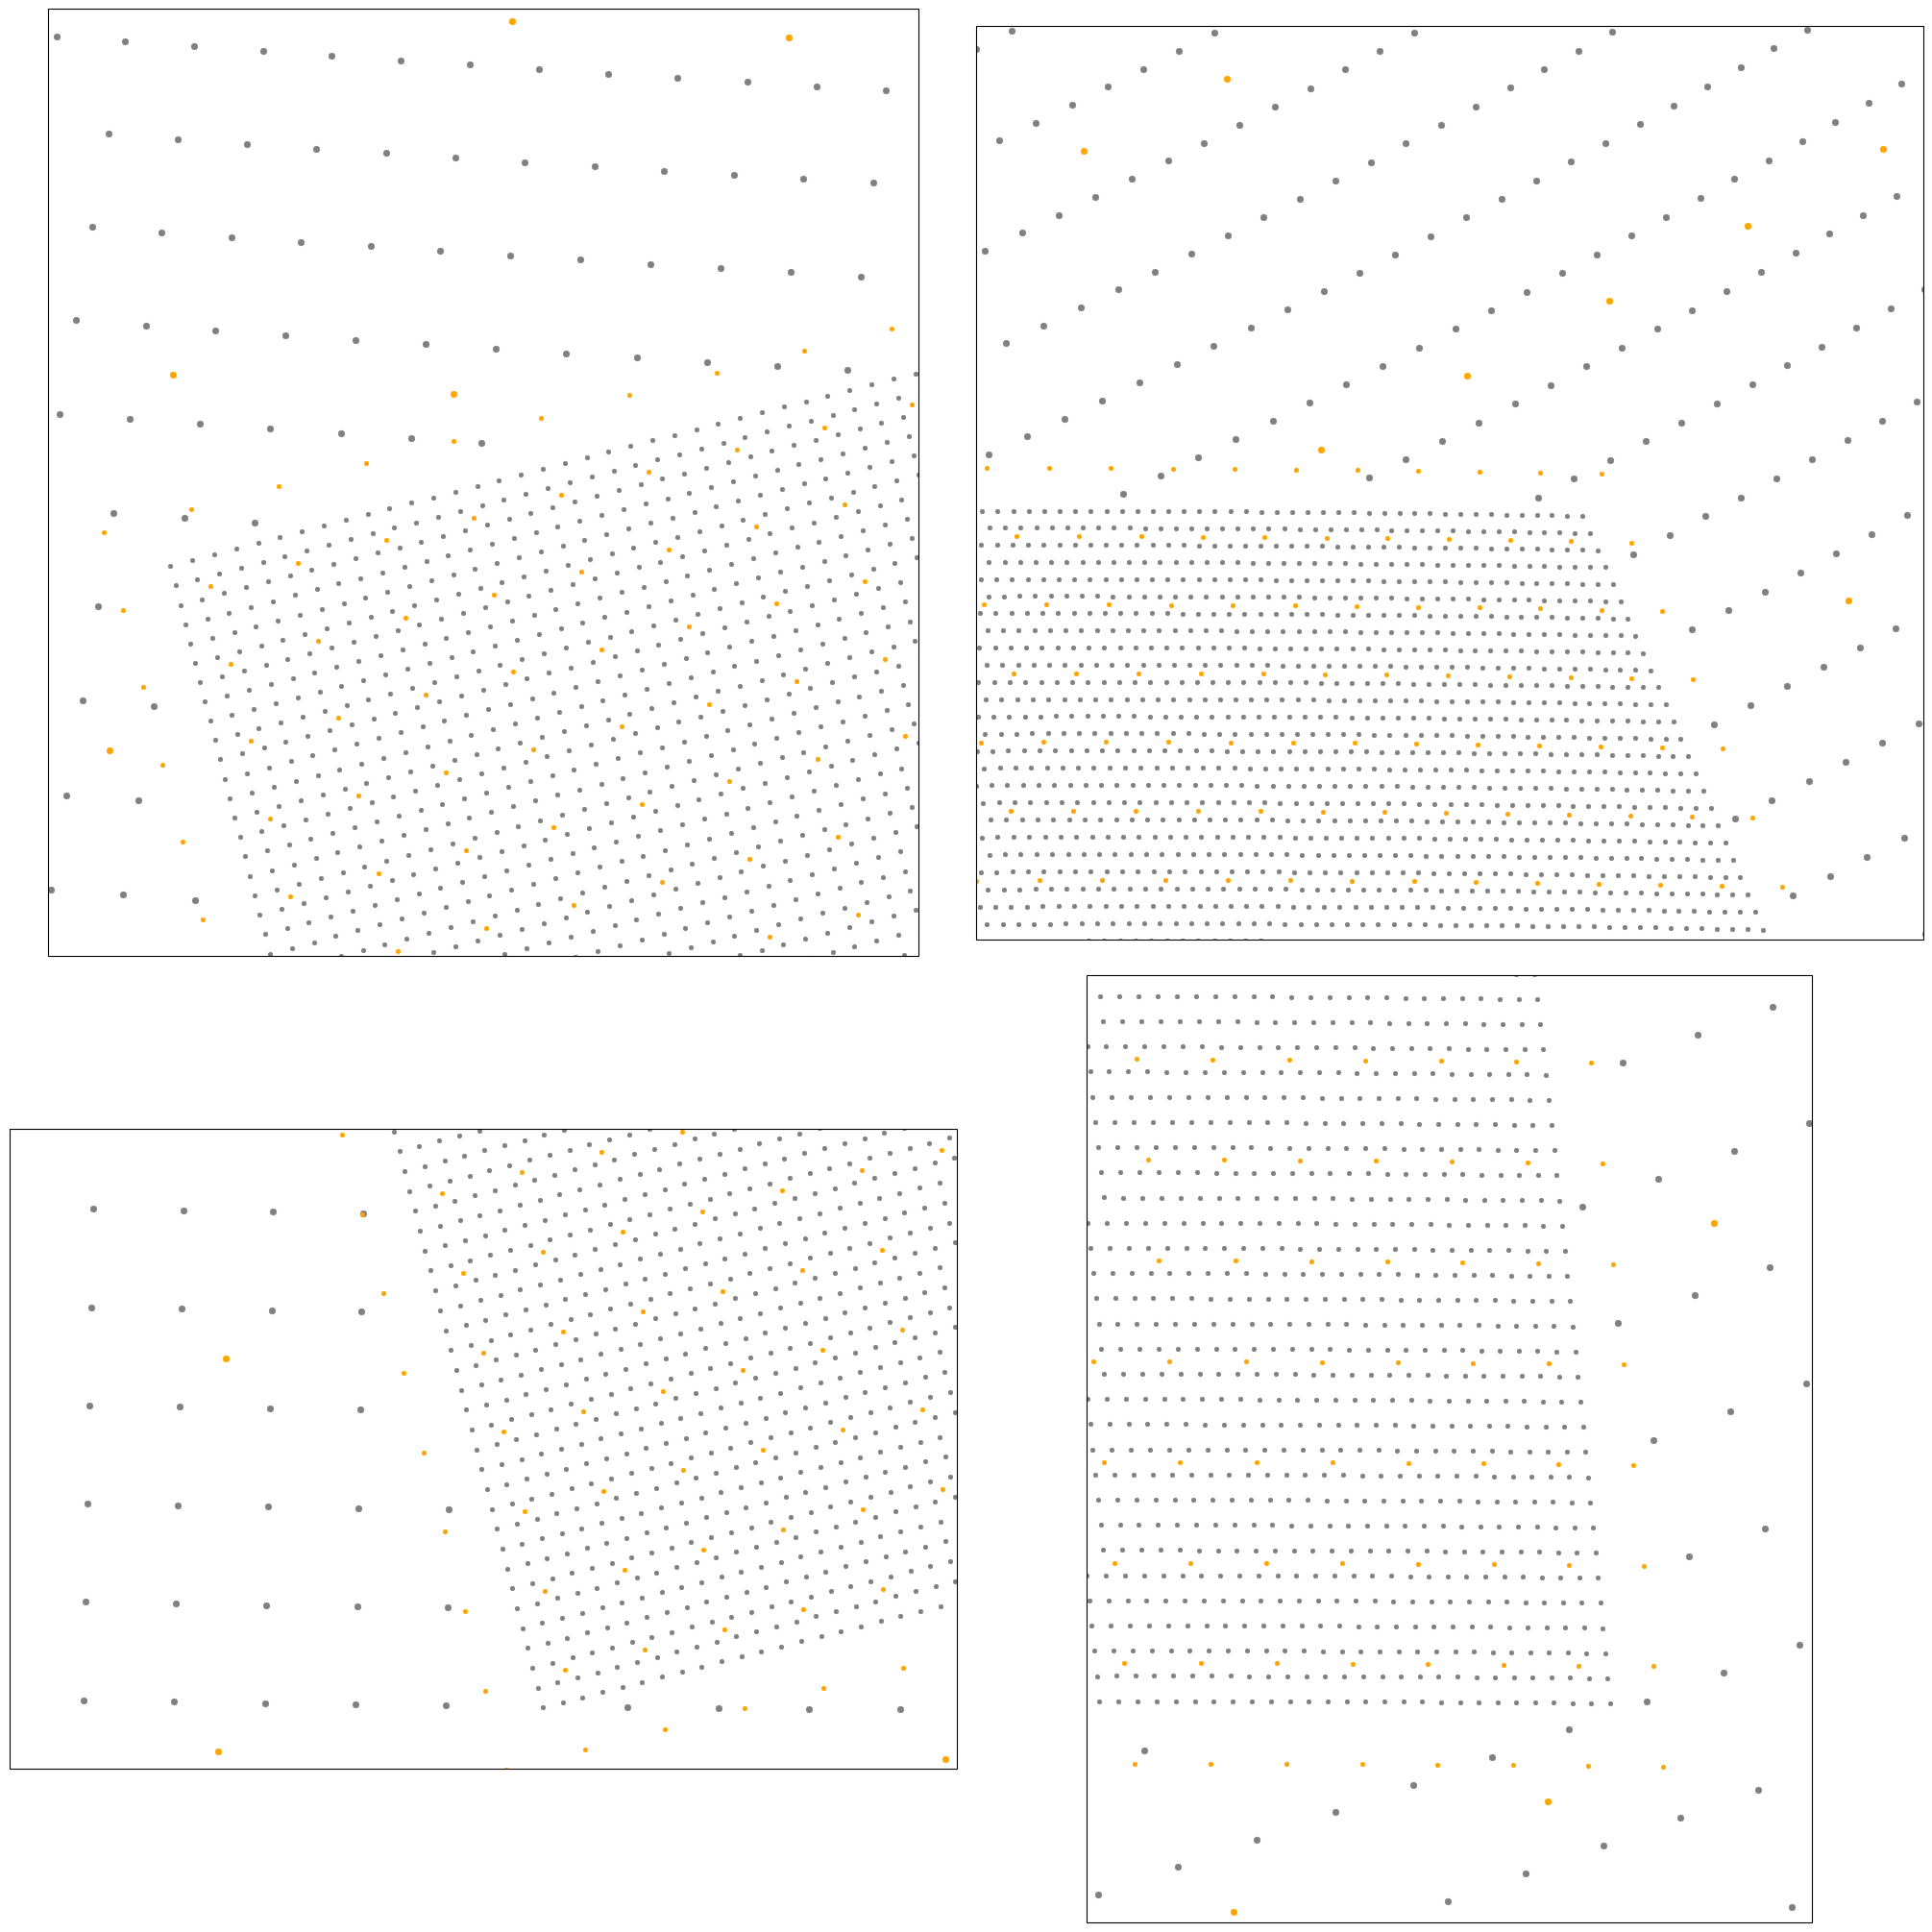

In [27]:
fig, axs = plt.subplots(
    2, 2,
    figsize=(20,20),
    subplot_kw={"projection": ccrs.Orthographic(central_longitude=-120, central_latitude=20)},
)

for x, y, x_d, y_d, s in zip(
    [glon.flatten()[mask], hmesh.lon.values.flatten()],
    [glat.flatten()[mask], hmesh.lat.values.flatten()],
    [data.longitudes[n_cutout:], data.longitudes[:n_cutout]],
    [data.latitudes[n_cutout:], data.latitudes[:n_cutout]],
    [24, 12],
):

    kw = {"transform": ccrs.PlateCarree(), "s": s}
    for ax in axs.flatten():
        ax.scatter(x,y, color="orange", **kw)
        ax.scatter(x_d, y_d, color="gray", **kw)
# The overview
#axs[0].set_extent([-140, -100, 20, 60], crs=ccrs.PlateCarree())
#axs[1].set_extent([-125, -115, 20, 30], crs=ccrs.PlateCarree())

axs[0, 0].set_extent([228.25, 230.85, 46.2, 48.6], crs=ccrs.PlateCarree())
axs[0, 1].set_extent([294.6, 297.2, 46.2, 48.6], crs=ccrs.PlateCarree())
axs[1, 0].set_extent([236.8, 239.4, 22.6, 24.2], crs=ccrs.PlateCarree())
axs[1, 1].set_extent([285.6, 287.2, 22.55, 24.2], crs=ccrs.PlateCarree())
#fig.savefig(f"mesh_and_data_nodes.jpeg", bbox_inches="tight", dpi=300)

Sort stuff out

In [28]:
clon = np.concatenate([glon.flatten()[mask], hmesh.lon.values.flatten()])
clat = np.concatenate([glat.flatten()[mask], hmesh.lat.values.flatten()])

In [29]:
print(glon.flatten()[mask].max(), glon.flatten()[mask].min())
print(glat.flatten()[mask].max(), glat.flatten()[mask].min())

359.375 0.375
89.625 -89.375


In [30]:
print(hmesh.lon.values.max(), hmesh.lon.values.min())
print(hmesh.lat.values.max(), hmesh.lat.values.min())

296.6507205735121 228.22563649051827
51.45089243674657 22.58876051600471


In [31]:
from anemoi.graphs.generate.utils import get_coordinates_ordering
# Lets not worry about radians? since lon is 0-360 in both and -90-90 in both
#from anemoi.graphs.generate.transforms import cartesian_to_latlon_rad

In [32]:
coords = np.stack([clon, clat], axis=-1)
order = get_coordinates_ordering(coords)

In [33]:
order

array([18847, 12239, 19150, ..., 58957, 21912,     0], shape=(89385,))

In [34]:
coords[:,0].min()

np.float64(0.375)

In [35]:
(coords[order] == coords[order,:]).all()

np.True_

In [36]:
cds = xr.Dataset(
    attrs={"n_cutout": n_cutout}
)

cds["lon"] = xr.DataArray(
    coords[order, 0],
    coords={"lon": coords[order, 0]},
)

clat = np.concatenate([glat.flatten()[mask], hmesh.lat.values.flatten()])
cds["lat"] = xr.DataArray(
    coords[order, 1],
    coords={"lat": coords[order,1]},
)

In [37]:
cds

<xarray.Dataset> Size: 1MB
Dimensions:  (lon: 89385, lat: 89385)
Coordinates:
  * lon      (lon) float64 715kB 359.4 359.4 359.4 359.4 ... 0.375 0.375 0.375
  * lat      (lat) float64 715kB 35.62 56.62 34.62 74.62 ... -78.38 24.62 89.62
Data variables:
    *empty*
Attributes:
    n_cutout:  407040

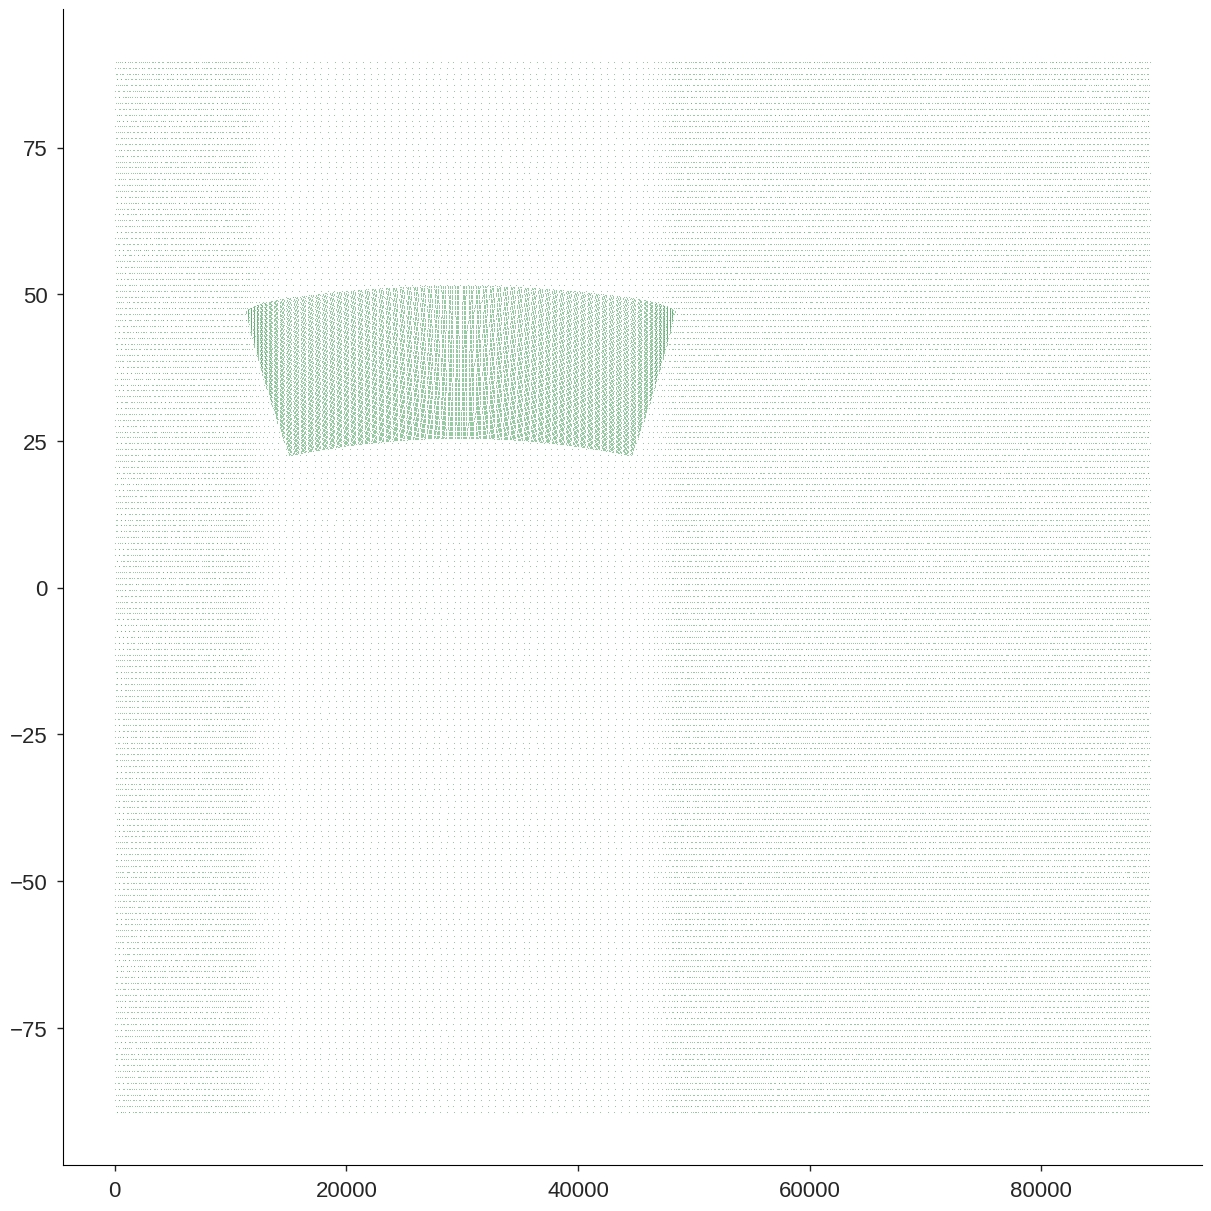

In [38]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(cds.lat.values, ls="", marker=".", markersize=1)

In [39]:
np.savez("latentx4.spongex1.combined.sorted.npz", lon=cds.lon.values, lat=cds.lat.values)

In [40]:
checkit = np.load("latentx4.spongex1.combined.sorted.npz")

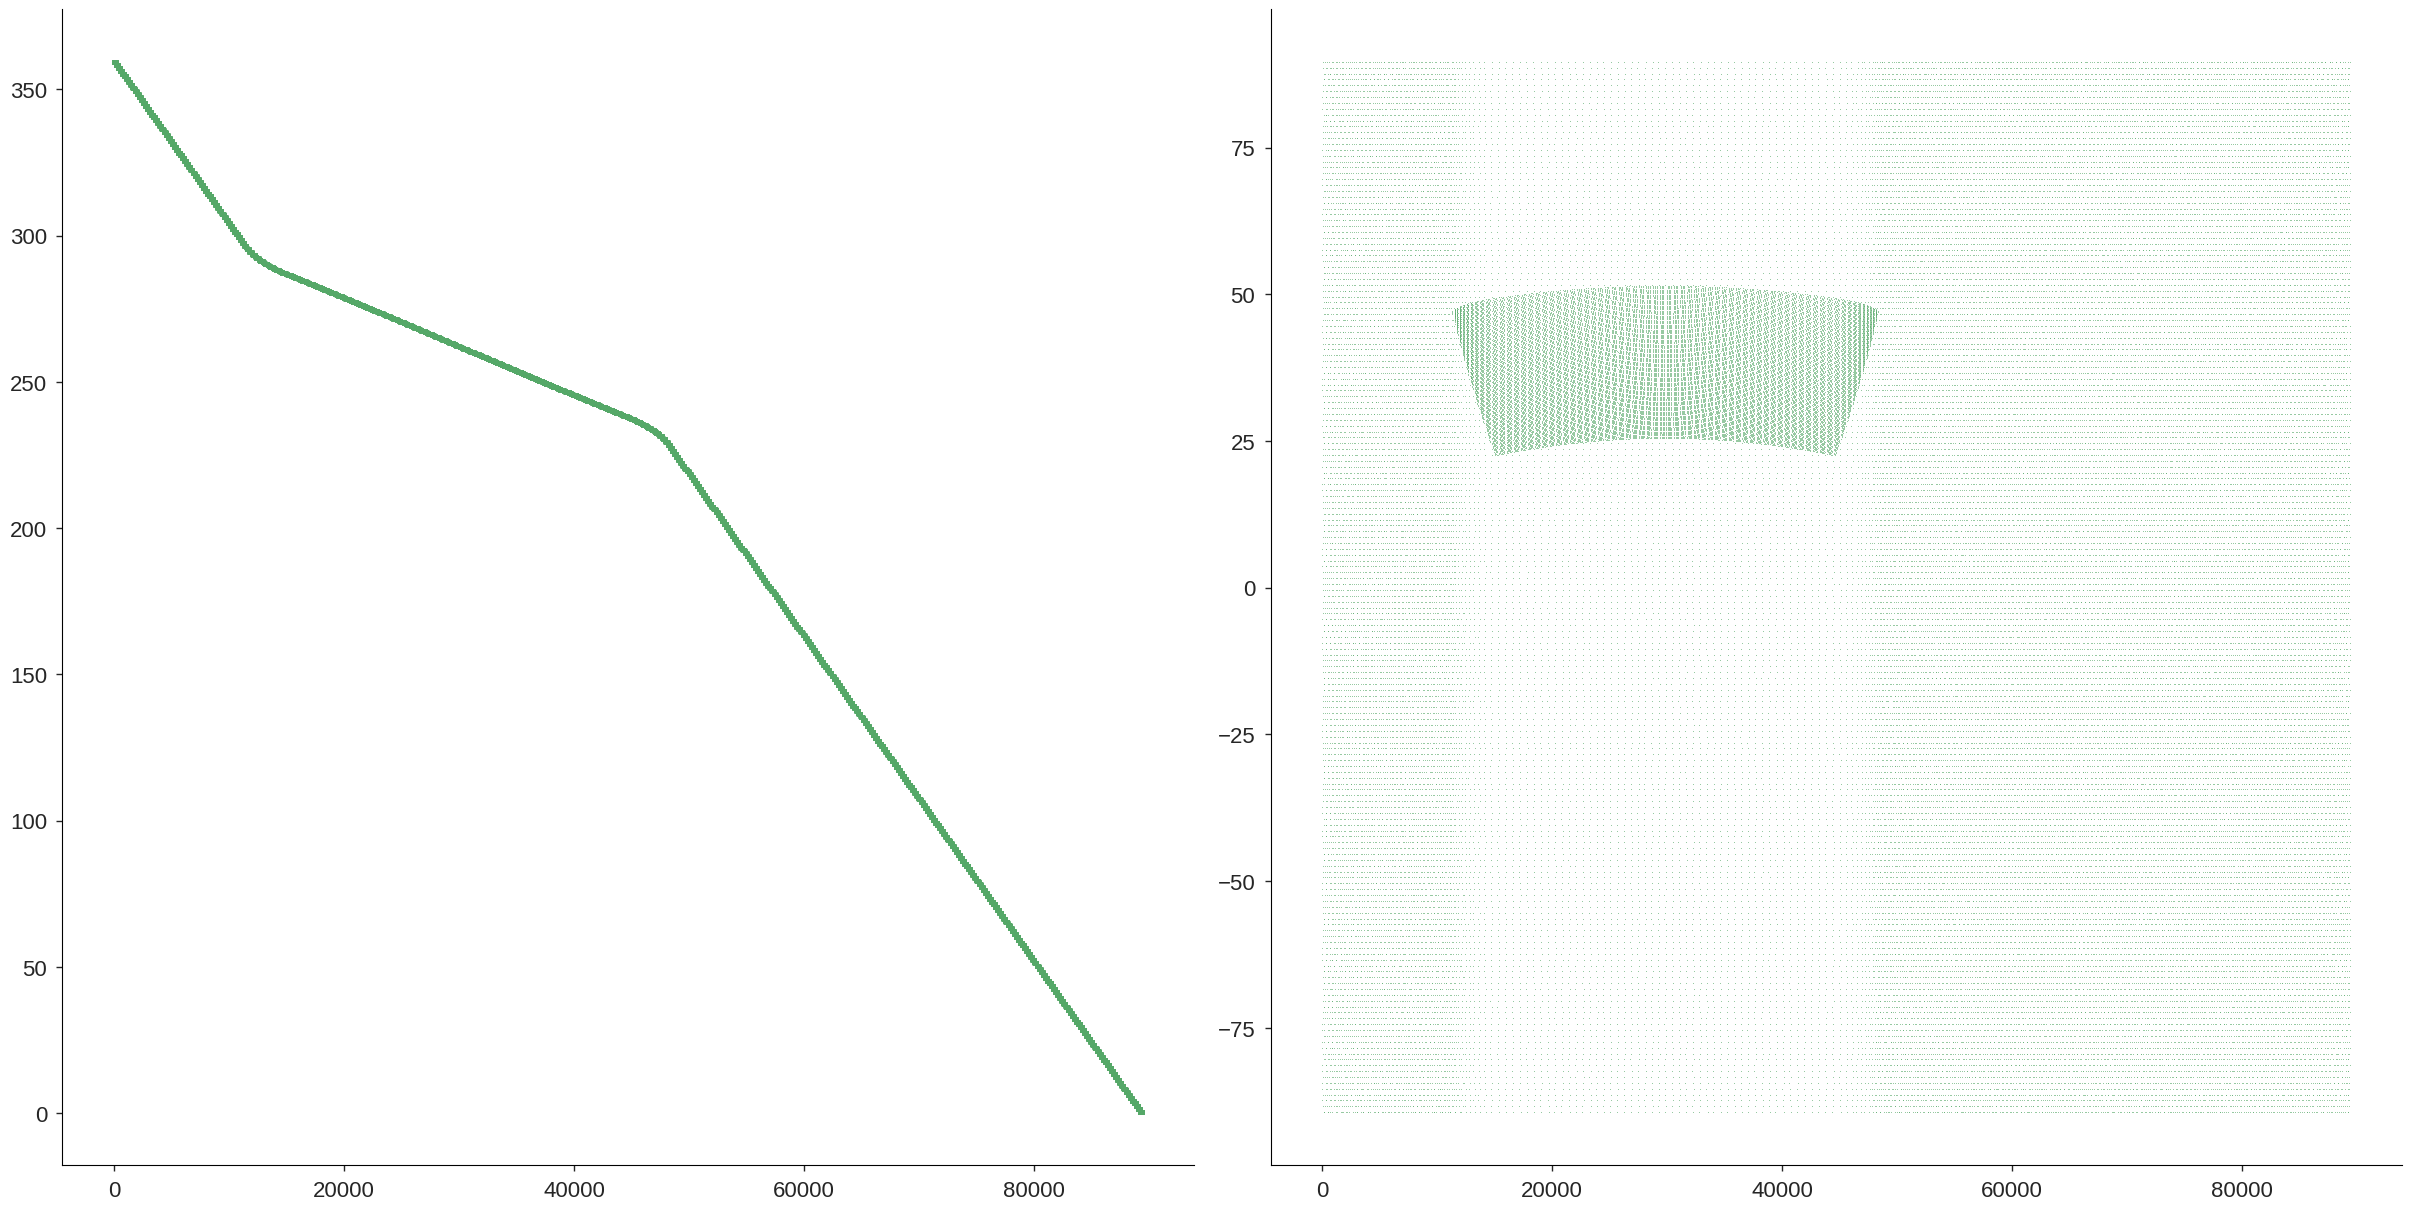

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(24, 12), constrained_layout=True)
axs[0].plot(checkit["lon"], ls="", marker=".")
axs[1].plot(checkit["lat"], ls="", marker=".",markersize=1)